### Meeting a Sayed Athar's request, I'm using the Kernel altered by Khoi Nguyen to explain how the whole code works.
### If any part is not clear, please comment.  
### Please upvote if it was helpful.

In [1]:
import pandas as pd
import pyarrow.parquet as pq # Used to read the data
import os 
import numpy as np
from keras.layers import * # Keras is the most friendly Neural Network library, this Kernel use a lot of layers classes
from keras.models import Model
from tqdm import tqdm # Processing time measurement
from sklearn.model_selection import train_test_split 
from keras import backend as K # The backend give us access to tensorflow operations and allow us to create the Attention class
from keras import optimizers # Allow us to access the Adam class to modify some parameters
from sklearn.model_selection import GridSearchCV, StratifiedKFold # Used to use Kfold to train our model
from keras.callbacks import * # This object helps the model to train in a smarter way, avoiding overfitting

from scipy.signal import chirp, find_peaks, peak_widths
import pywt

from multiprocessing import Pool
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import warnings

warnings.filterwarnings('ignore')

import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

/home/cwademo123/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# select how many folds will be created
N_SPLITS = 5
# it is just a constant with the measurements data size
sample_size = 800000

In [3]:
def matthews_correlation(y_true, y_pred):
    '''Calculates the Matthews correlation coefficient measure for quality
    of binary classification problems.
    '''
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos

    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos

    tp = K.sum(y_pos * y_pred_pos)
    tn = K.sum(y_neg * y_pred_neg)

    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)

    numerator = (tp * tn - fp * fn)
    denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

    return numerator / (denominator + K.epsilon())

In [4]:
# https://www.kaggle.com/suicaokhoailang/lstm-attention-baseline-0-652-lb

class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        
        x = K.concatenate([weighted_input, x], axis=2)
        return x

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[1], self.features_dim*2

In [5]:
# just load train data
df_train = pd.read_csv('../input/metadata_train.csv')
# set index, it makes the data access much faster
df_train = df_train.set_index(['id_measurement', 'phase'])
df_train.head()

signal_id  target
id_measurement phase                   
0              0              0       0
               1              1       0
               2              2       0
1              0              3       1
               1              4       1

In [6]:
# in other notebook I have extracted the min and max values from the train data, the measurements
max_num = 127
min_num = -128

In [7]:
# This function standardize the data from (-128 to 127) to (-1 to 1)
# Theoretically it helps in the NN Model training, but I didn't tested without it
def min_max_transf(ts, min_data, max_data, range_needed=(-1,1)):
    if min_data < 0:
        ts_std = (ts + abs(min_data)) / (max_data + abs(min_data))
    else:
        ts_std = (ts - min_data) / (max_data - min_data)
    if range_needed[0] < 0:    
        return ts_std * (range_needed[1] + abs(range_needed[0])) + range_needed[0]
    else:
        return ts_std * (range_needed[1] - range_needed[0]) + range_needed[0]

In [8]:
def maddest(d, axis=None):
    """
    Mean Absolute Deviation
    """
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

In [9]:
def denoise_signal( x, wavelet='db4', level=1):
    """
    1. Adapted from waveletSmooth function found here:
    http://connor-johnson.com/2016/01/24/using-pywavelets-to-remove-high-frequency-noise/
    2. Threshold equation and using hard mode in threshold as mentioned
    in section '3.2 denoising based on optimized singular values' from paper by Tomas Vantuch:
    http://dspace.vsb.cz/bitstream/handle/10084/133114/VAN431_FEI_P1807_1801V001_2018.pdf
    """
    
    # Decompose to get the wavelet coefficients
    coeff = pywt.wavedec( x, wavelet, mode="per", level=level)
    
    # Calculate sigma for threshold as defined in http://dspace.vsb.cz/bitstream/handle/10084/133114/VAN431_FEI_P1807_1801V001_2018.pdf
    # As noted by @harshit92 MAD referred to in the paper is Mean Absolute Deviation not Median Absolute Deviation
    sigma = (1/0.6745) * maddest( coeff[-level] )

    # Calculte the univeral threshold
    uthresh = sigma * np.sqrt( 2*np.log( len( x ) ) )
    coeff[1:] = ( pywt.threshold( i, value=uthresh, mode='hard' ) for i in coeff[1:] )
    
    # Reconstruct the signal using the thresholded coefficients
    return pywt.waverec( coeff[1:], wavelet, mode='per' )

In [10]:
def denoise_signal_2( x, wavelet='db4', level=1):
    """
    1. Adapted from waveletSmooth function found here:
    http://connor-johnson.com/2016/01/24/using-pywavelets-to-remove-high-frequency-noise/
    2. Threshold equation and using hard mode in threshold as mentioned
    in section '3.2 denoising based on optimized singular values' from paper by Tomas Vantuch:
    http://dspace.vsb.cz/bitstream/handle/10084/133114/VAN431_FEI_P1807_1801V001_2018.pdf
    """
    
    # Decompose to get the wavelet coefficients
    coeff = pywt.wavedec( x, wavelet, mode="per", level=level)
    
    # Calculate sigma for threshold as defined in http://dspace.vsb.cz/bitstream/handle/10084/133114/VAN431_FEI_P1807_1801V001_2018.pdf
    # As noted by @harshit92 MAD referred to in the paper is Mean Absolute Deviation not Median Absolute Deviation
    sigma = (1/0.6745) * maddest( coeff[-level] )

    # Calculte the univeral threshold
    uthresh = sigma * np.sqrt( 2*np.log( len( x ) ) )
    coeff[1:] = ( pywt.threshold( i, value=uthresh, mode='hard' ) for i in coeff[1:] )
    
    # Reconstruct the signal using the thresholded coefficients
    return pywt.waverec( coeff[0:], wavelet, mode='per' )

In [11]:
def remove_corona(x_dn, maxDistance=10, maxHeightRatio=0.25, maxTicksRemoval=500):
    index = pd.Series(x_dn).loc[np.abs(x_dn)>0].index
    corona_idx = []
    for idx in index:
        for i in range(1,maxDistance+1):
            if idx+i < pd.Series(x_dn).shape[0]:
                if x_dn[idx+i]/(x_dn[idx]+1e-04)<-maxHeightRatio:
                    x_dn[idx:idx+maxTicksRemoval] = 0
                    corona_idx.append(idx)
    return x_dn, corona_idx

In [12]:
# This is one of the most important peace of code of this Kernel
# Any power line contain 3 phases of 800000 measurements, or 2.4 millions data 
# It would be praticaly impossible to build a NN with an input of that size
# The ideia here is to reduce it each phase to a matrix of <n_dim> bins by n features
# Each bean is a set of 5000 measurements (800000 / 160), so the features are extracted from this 5000 chunk data.
def transform_ts(ts, n_dim=160, min_max=(-1,1)):
    # convert data into -1 to 1
    ts_std = min_max_transf(ts, min_data=min_num, max_data=max_num)
    # bucket or chunk size, 5000 in this case (800000 / 160)
    bucket_size = int(sample_size / n_dim)
    # new_ts will be the container of the new data
    
    new_ts = []
    # this for iteract any chunk/bucket until reach the whole sample_size (800000)
    for i in range(0, sample_size, bucket_size):
        # cut each bucket to ts_range
        ts_range = ts_std[i:i + bucket_size]
        
        # calculate each feature
        mean = ts_range.mean()
        std = ts_range.std() # standard deviation
        std_top = mean + std # I have to test it more, but is is like a band
        std_bot = mean - std
        # I think that the percentiles are very important, it is like a distribuiton analysis from eath chunk
        percentil_calc = np.percentile(ts_range, [0, 1, 25, 50, 75, 99, 100]) 
        max_range = percentil_calc[-1] - percentil_calc[0] # this is the amplitude of the chunk
        relative_percentile = percentil_calc - mean # maybe it could heap to understand the asymmetry
                
        
        
        feat_array = np.asarray([mean, std, std_top, std_bot, max_range], dtype=np.float16)
        
        new_ts.append(np.concatenate([feat_array
                                      , percentil_calc, relative_percentile]))
    
        
    return new_ts

In [13]:
# this function take a piece of data and convert using transform_ts(), but it does to each of the 3 phases
# if we would try to do in one time, could exceed the RAM Memmory
def prep_data(start, end):
    # load a piece of data from file
    praq_train = pq.read_pandas('../input/train.parquet', columns=[str(i) for i in range(start, end)]).to_pandas()
    
    X = []
    y = []
    
    for id_measurement in tqdm(df_train.index.levels[0].unique()[int(start/3):int(end/3)]):
        X_signal = []
        # for each phase of the signal
        for phase in [0,1,2]:
            # extract from df_train both signal_id and target to compose the new data sets
            signal_id, target = df_train.loc[id_measurement].loc[phase]
            # but just append the target one time, to not triplicate it
            if phase == 0:
                y.append(target)                
            # extract and transform data into sets of features
            X_signal.append(transform_ts(np.asarray(praq_train[str(signal_id)], dtype=np.float16)))
        # concatenate all the 3 phases in one matrix
        X_signal = np.concatenate(X_signal, axis=1)
        # add the data to X
        X.append(X_signal)
    
    
    roopsize = [101000, 202000, 303000, 404000, 505000, 606000, 707000]
    
    for r_size in roopsize:
        roop = praq_train.iloc[praq_train.shape[0]-r_size:, :]
        praq_train_2 = pd.concat([roop, praq_train], axis=0).iloc[:800000, :]
    
        for id_measurement in tqdm(df_train.index.levels[0].unique()[int(start/3):int(end/3)]):    
            X_signal = []
            # for each phase of the signal
            for phase in [0,1,2]:
                # extract from df_train both signal_id and target to compose the new data sets
                signal_id, target = df_train.loc[id_measurement].loc[phase]
                # but just append the target one time, to not triplicate it
                if phase == 0:
                    y.append(target)                
                # extract and transform data into sets of features
                X_signal.append(transform_ts(np.asarray(praq_train_2[str(signal_id)], dtype=np.float16)))
            # concatenate all the 3 phases in one matrix
            X_signal = np.concatenate(X_signal, axis=1)
            # add the data to X
            X.append(X_signal)
    # using tdqm to evaluate processing time
    # takes each index from df_train and iteract it from start to end
    # it is divided by 3 because for each id_measurement there are 3 id_signal, and the start/end parameters are id_signal
       
    X = np.asarray(X, dtype=np.float16)
    y = np.asarray(y, dtype=np.int16)
    return X, y

In [14]:
def process_subtrain(arg_tuple):
    start, end, idx = arg_tuple
    X, y = prep_data(start, end)
    return idx, X, y

In [15]:
praq_train = pq.read_pandas('../input/train.parquet', columns=[str(i) for i in range(0, 8712)]).to_pandas()

In [18]:
praq_train = np.asarray(praq_train, dtype=np.float16)

In [16]:
praq_train.shape

(800000, 8712)

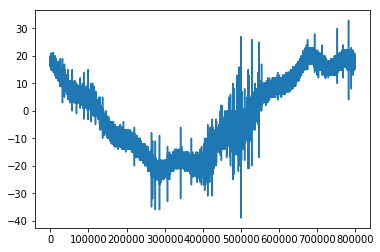

In [19]:
plt.plot(praq_train.T[0, :])

In [23]:
X = np.zeros((int(800000/10), praq_train.shape[1]), dtype=np.float16)
for i in tqdm(range(0, 800000, 10)):
    X[int(i/10), :] = np.sum(praq_train[i:i+10, :], axis=0)/10


 13%|█▎        | 10144/80000 [00:14<01:39, 703.44it/s]


 25%|██▌       | 20008/80000 [00:29<01:32, 648.21it/s]


 37%|███▋      | 29761/80000 [00:43<01:13, 685.45it/s]


 49%|████▉     | 39586/80000 [00:58<00:59, 673.74it/s]


 61%|██████▏   | 49196/80000 [01:12<00:47, 643.82it/s]


 74%|███████▎  | 58831/80000 [01:27<00:32, 654.46it/s]


 86%|████████▌ | 68734/80000 [01:41<00:15, 706.45it/s]


 98%|█████████▊| 78536/80000 [01:56<00:02, 628.04it/s]


100%|██████████| 80000/80000 [01:58<00:00, 676.00it/s]

In [26]:
X = X.T
X = min_max_transf(X, min_data=min_num, max_data=max_num)

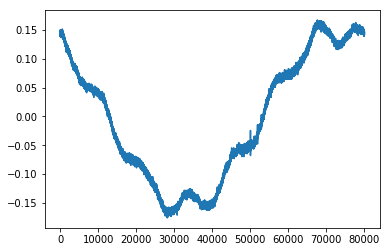

In [27]:
plt.plot(X[0, :])

In [29]:
X = X.reshape(8712, 1, 80000)
y = df_train['target'].values
np.save('X_14.npy',X)

In [ ]:
for i in tqdm(range(8712)):
    praq_train[i] = min_max_transf(praq_train[i], min_data=min_num, max_data=max_num)

In [ ]:
X = praq_train.reshape(8712, 1, 800000)

In [ ]:
y = df_train['target'].values

In [ ]:
np.save('X_14.npy',X)

In [ ]:
import gc

del praq_train
gc.collect()

In [ ]:
# this code is very simple, divide the total size of the df_train into two sets and process it
#X = []
#y = []
all_chunks = []

num_cores = 8 
#def load_all():
total_size = len(df_train)
chunk_size = total_size/num_cores

for i in range(8):
    start_idx = int(i * chunk_size)
    end_idx = int(start_idx + chunk_size)
    chunk = (start_idx, end_idx, i)
    all_chunks.append(chunk)

pool = Pool()
results = pool.map(process_subtrain, all_chunks)    
results = sorted(results, key=lambda tup: tup[0])

X = np.concatenate([item[1] for item in results], axis=0)
y = np.concatenate([item[2] for item in results], axis=0)

#load_all()

#X = np.asarray(X)
#y = np.asarray(y)

In [ ]:
# The X shape here is very important. It is also important undertand a little how a LSTM works
# X.shape[0] is the number of id_measuremts contained in train data
# X.shape[1] is the number of chunks resultant of the transformation, each of this date enters in the LSTM serialized
# This way the LSTM can understand the position of a data relative with other and activate a signal that needs
# a serie of inputs in a specifc order.
# X.shape[3] is the number of features multiplied by the number of phases (3)
print(X.shape, y.shape)

In [ ]:
print(X.dtype, y.dtype)

In [ ]:
# save data into file, a numpy specific format
np.save("X_13.npy",X)
np.save("y_13.npy",y)

In [ ]:
X_0 = X[:2904]
X_1 = X[2904:5808]
X_2 = X[5808:8712]
X_3 = X[8712:11616]
X_4 = X[11616:]

In [ ]:
print(X_0.shape, X_1.shape, X_2.shape, X_3.shape, X_4.shape)

In [ ]:
List_X = []
for i in range(2904):
    Shin_X = np.concatenate([X_0[i], X_1[i], X_2[i], X_3[i], X_4[i]], axis=0)
    Shin_X = Shin_X.reshape((-1, 160, 57))
    List_X.append(Shin_X)
List_X = np.asarray(List_X, dtype=np.float16).reshape(-1, 160, 57)

In [ ]:
y_0 = y[:2904]
y_1 = y[2904:5808]
y_2 = y[5808:8712]
y_3 = y[8712:11616]
y_4 = y[11616:]

In [ ]:
print(y_0.shape, y_1.shape, y_2.shape, y_3.shape, y_4.shape)

In [ ]:
List_y = []
for i in range(2904):
    Shin_y = np.asarray([y_0[i], y_1[i], y_2[i], y_3[i], y_4[i]])
    #Shin_y = Shin_X.reshape((-1, 160, 57))
    List_y.append(Shin_y)
List_y = np.asarray(List_y, dtype=np.float16).reshape(-1)

In [ ]:
List_y.shape

In [ ]:
np.save("X_11.npy", List_X)
np.save("y_11.npy",List_y)

In [ ]:
List_X.shape

In [ ]:
List_X[1]==X[2904]

In [ ]:
Shin_X.reshape((-1, 160, 57)).shape

In [ ]:
X = np.load("./X.npy")
y = np.load("./y.npy")

In [ ]:
class SimpleAttention(Layer):
  
    def __init__(self, depth:int, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.depth = depth
        self.q_dense_layer = Dense(depth, use_bias=False)
        self.k_dense_layer = Dense(depth, use_bias=False)
        self.v_dense_layer = Dense(depth, use_bias=False)
        self.output_dense_layer = Dense(depth, use_bias=False)
    
    def call(self, inp):
        q = self.q_dense_layer(inp)  # [batch_size, q_length, depth]
        q *= self.depth ** -0.5
        print(q.shape)
        
        k = self.k_dense_layer(inp)  # [batch_size, m_length, depth]
        v = self.v_dense_layer(inp)

        logit = tf.matmul(q, k, transpose_b=True)
        print(logit.shape)
        
        attention_weight = tf.nn.softmax(logit, name='attention_weight')
        
        attention_output = tf.matmul(attention_weight, v)  # [batch_size, q_length, depth]
        print(attention_output.shape)
        
        x = self.output_dense_layer(attention_output) + q
        print(x.shape)
        
        
        return x
    
    def compute_output_shape(self, input_shape):
        if len(input_shape)==3:
            return input_shape[0], input_shape[1], self.depth
        if len(input_shape)==4:
            return input_shape[0], input_shape[1], input_shape[2], self.depth

In [34]:
# This is NN LSTM Model creation
def model_lstm(input_shape):
    # The shape was explained above, must have this order
    inp = Input(shape=(input_shape[1], input_shape[2],))
    #print(inp.shape)
     
    
    #x = Masking()(x)
    x = LSTM(128)(inp)
    x = Dropout(0.8)(x)
    
    y = Permute((2, 1))(inp)
    y = Conv1D(128, 8, padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    #y = squeeze_excite_block(y)

    y = Conv1D(256, 5, padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    #y = squeeze_excite_block(y)

    y = Conv1D(128, 3, padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)

    y = GlobalAveragePooling1D()(y)

    x = concatenate([x, y])

    out = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=inp, outputs=out)
    # Pay attention in the addition of matthews_correlation metric in the compilation, it is a success factor key
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[matthews_correlation])
    
    return model

In [35]:
# Here is where the training happens

# First, create a set of indexes of the 5 folds
splits = list(StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=2019).split(X, y))
preds_val = []
y_val = []
# Then, iteract with each fold
# If you dont know, enumerate(['a', 'b', 'c']) returns [(0, 'a'), (1, 'b'), (2, 'c')]
for idx, (train_idx, val_idx) in enumerate(splits):
    K.clear_session() # I dont know what it do, but I imagine that it "clear session" :)
    print("Beginning fold {}".format(idx+1))
    # use the indexes to extract the folds in the train and validation data
    train_X, train_y, val_X, val_y = X[train_idx], y[train_idx], X[val_idx], y[val_idx]
    # instantiate the model for this fold
    model = model_lstm(train_X.shape)
    # This checkpoint helps to avoid overfitting. It just save the weights of the model if it delivered an
    # validation matthews_correlation greater than the last one.
    ckpt = ModelCheckpoint('weights_{}.h5'.format(idx), save_best_only=True, save_weights_only=True, verbose=1, monitor='val_matthews_correlation', mode='max')
    # Train, train, train
    model.fit(train_X, train_y, batch_size=256, epochs=50, validation_data=[val_X, val_y], callbacks=[ckpt])
    # loads the best weights saved by the checkpoint
    model.load_weights('weights_{}.h5'.format(idx))
    # Add the predictions of the validation to the list preds_val
    preds_val.append(model.predict(val_X, batch_size=512))
    # and the val true y
    y_val.append(val_y)

# concatenates all and prints the shape    
preds_val = np.concatenate(preds_val)[...,0]
y_val = np.concatenate(y_val)
preds_val.shape, y_val.shape

Beginning fold 1
Train on 6969 samples, validate on 1743 samples
Epoch 1/50


ResourceExhaustedError: OOM when allocating tensor with shape[256,1,80000,128] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
	 [[{{node conv1d_1/convolution/Conv2D}} = Conv2D[T=DT_FLOAT, _class=["loc:@train...propFilter"], data_format="NHWC", dilations=[1, 1, 1, 1], padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:CPU:0"](conv1d_1/convolution/ExpandDims, conv1d_1/convolution/ExpandDims_1)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


In [ ]:
np.save('./tmp/y_val_tmp_8.npy', y_val)
np.save('./tmp/preds_val_tmp_8.npy', preds_val)

In [ ]:
# It is the official metric used in this competition
# below is the declaration of a function used inside the keras model, calculation with K (keras backend / thensorflow)
def matthews_correlation(y_true, y_pred):
    '''Calculates the Matthews correlation coefficient measure for quality
    of binary classification problems.
    '''
    
    #y_pred = K.cast(y_pred, np.float)
    y_pred_pos = np.round(np.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos

    y_pos = np.round(np.clip(y_true, 0, 1))
    y_neg = 1 - y_pos

    tp = np.sum(y_pos * y_pred_pos)
    tn = np.sum(y_neg * y_pred_neg)

    fp = np.sum(y_neg * y_pred_pos)
    fn = np.sum(y_pos * y_pred_neg)

    numerator = (tp * tn - fp * fn)
    denominator = np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

    return numerator / (denominator + K.epsilon())

In [ ]:
# The output of this kernel must be binary (0 or 1), but the output of the NN Model is float (0 to 1).
# So, find the best threshold to convert float to binary is crucial to the result
# this piece of code is a function that evaluates all the possible thresholds from 0 to 1 by 0.01
def threshold_search(y_true, y_proba):
    best_threshold = 0
    best_score = 0
    for threshold in tqdm([i * 0.01 for i in range(100)]):
        #score = matthews_correlation(y_true, (y_proba > threshold).astype(int))
        #score = K.eval(matthews_correlation(y_true, (y_proba > threshold).astype(int)))
        #score = K.eval(matthews_correlation(y_true.astype(np.float64), (y_proba > threshold).astype(np.float64)))
        score = matthews_correlation(y_true.astype(np.float64), (y_proba > threshold).astype(np.float64))
        if score > best_score:
            best_threshold = threshold
            best_score = score
    search_result = {'threshold': best_threshold, 'matthews_correlation': best_score}
    return search_result

In [ ]:
best_threshold = threshold_search(y_val, preds_val)['threshold']

In [ ]:
best_threshold

In [ ]:
matthews_correlation(y_val, preds_val)

In [ ]:
%%time
# Now load the test data
# This first part is the meta data, not the main data, the measurements
meta_test = pd.read_csv('../input/metadata_test.csv')
df_test = meta_test.set_index(['id_measurement', 'phase'])

In [ ]:
meta_test = meta_test.set_index(['signal_id'])
meta_test.head()

In [ ]:
# this function take a piece of data and convert using transform_ts(), but it does to each of the 3 phases
# if we would try to do in one time, could exceed the RAM Memmory
def prep_data_test(start, end):
    # load a piece of data from file
    praq_test = pq.read_pandas('../input/test.parquet', columns=[str(i) for i in range(start+8712, end+8712)]).to_pandas()
    X = []

    # using tdqm to evaluate processing time
    # takes each index from df_train and iteract it from start to end
    # it is divided by 3 because for each id_measurement there are 3 id_signal, and the start/end parameters are id_signal
    for id_measurement in tqdm(df_test.index.levels[0].unique()[int(start/3):int(end/3)]):
        X_signal = []
        # for each phase of the signal
        for phase in [0,1,2]:
            # extract from df_train both signal_id and target to compose the new data sets
            signal_id = df_test.loc[id_measurement].loc[phase][0]
            # but just append the target one time, to not triplicate it
            #if phase == 0:
                #ts_1 = min_max_transf(praq_test[str(signal_id)], min_data=min_num, max_data=max_num)
                #ts_2 = min_max_transf(praq_test[str(signal_id+1)], min_data=min_num, max_data=max_num)
                #ts_3 = min_max_transf(praq_test[str(signal_id+2)], min_data=min_num, max_data=max_num)
                
                #ts_wave_1 = denoise_signal(ts_1, wavelet='haar', level=1)
                #ts_wave_2 = denoise_signal(ts_2, wavelet='haar', level=1)
                #ts_wave_3 = denoise_signal(ts_3, wavelet='haar', level=1)
                
                #ts_rm_1, _ = remove_corona(ts_wave_1)
                #ts_rm_2, _ = remove_corona(ts_wave_2)
                #ts_rm_3, _ = remove_corona(ts_wave_3)
                
                #ts_sum = ts_rm_1 + ts_rm_2 + ts_rm_3
                #X_signal.append(transform_ts_sum(ts_sum))
            # extract and transform data into sets of features
            X_signal.append(transform_ts(praq_test[str(signal_id)]))
        # concatenate all the 3 phases in one matrix
        X_signal = np.concatenate(X_signal, axis=1)
        # add the data to X
        X.append(X_signal)
    X = np.asarray(X)
    return X

In [ ]:
def process_subtest(arg_tuple):
    start, end, idx = arg_tuple
    X = prep_data_test(start, end)
    return idx, X

In [ ]:
all_chunks = []

num_cores = 16 
#def load_all():
total_size = len(meta_test)
chunk_size = np.ceil(total_size/num_cores)
#train_size = len(df_train)

for i in range(16):
    if i != 15:
        start_idx = int(i * chunk_size)
        end_idx = int(start_idx + chunk_size)
        #chunk = (start_idx+train_size, end_idx+train_size, i)
        chunk = (start_idx, end_idx, i)
        all_chunks.append(chunk)
    else:
        start_idx = int(i * chunk_size)
        end_idx = int(total_size)
        #chunk = (start_idx+train_size, end_idx+train_size, i)
        chunk = (start_idx, end_idx, i)
        all_chunks.append(chunk)
        

In [ ]:
pool = Pool()
results_1 = pool.map(process_subtest, all_chunks[0:8])    
results_1 = sorted(results_1, key=lambda tup: tup[0])

In [ ]:
results_2 = pool.map(process_subtest, all_chunks[8:16])    
results_2 = sorted(results_2, key=lambda tup: tup[0])

In [ ]:
results = results_1 + results_2
X_test = np.concatenate([item[1] for item in results], axis=0)

In [ ]:
np.save("X_test_7.npy",X_test)

In [ ]:
X_test = np.load('./X_test.npy')

In [ ]:
X_test.shape

In [ ]:
submission = pd.read_csv('../input/sample_submission.csv')
print(len(submission))
submission.head()

splits = list(StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=2019).split(X, y))

for idx, (train_idx, val_idx) in enumerate(splits):
    K.clear_session() # I dont know what it do, but I imagine that it "clear session" :)
    print("Beginning fold {}".format(idx+1))
    # use the indexes to extract the folds in the train and validation data
    train_X, train_y, val_X, val_y = X[train_idx], y[train_idx], X[val_idx], y[val_idx]
    # instantiate the model for this fold
    model = model_lstm(train_X.shape)

In [ ]:
preds_test = []
for i in range(5):
    model.load_weights('weights_{}.h5'.format(i))
    pred = model.predict(X_test, batch_size=300, verbose=1)
    pred_3 = []
    for pred_scalar in pred:
        for i in range(3):
            pred_3.append(pred_scalar)
    preds_test.append(pred_3)

In [ ]:
preds_test_2 = (np.squeeze(np.mean(preds_test, axis=0)) > best_threshold).astype(np.int)
preds_test_2.shape

In [ ]:
submission['target'] = preds_test_2
submission.to_csv('../output/submission_28.csv', index=False)
submission.head()

In [ ]:
lstm_preds = np.squeeze(np.mean(preds_test, axis=0))
np.save("./lstm_preds.npy", lstm_preds)

In [ ]:
np.sum(preds_test_2[preds_test_2==1])

In [ ]:
submission['target'].value_counts()

In [ ]:
model.load_weights('weights_0.h5')
pred = model.predict(X_test, batch_size=300, verbose=1)
pred_3 = []
for pred_scalar in pred:
    for i in range(3):
        pred_3.append(pred_scalar)

In [ ]:
pred_3>0.5

In [ ]:
preds_3 = (np.squeeze(pred_3) > 0.5).astype(np.int)

In [ ]:
np.sum(preds_3[preds_3==1])

In [ ]:
submission['target'] = preds_3
submission.to_csv('../output/submission_22.csv', index=False)

In [ ]:
submission['target'].value_counts()